In [7]:
import json
import matplotlib.pyplot as plt
import datetime

# Nummer des Labelschemas, das ausgewertet werden soll 
#  1=Skillevel, 2=CompoundSkills, 3=DividedSkills (CV-weise), 4=DividedSkills (zeilenweise), 
labelschemaNumber = 4

"""
Lädt Ergebnissedatei
"""
def loadData():
    results = None
    with open('./TestModelle/Results_Modell_{}.jsonl'.format(labelschemaNumber), 'r', encoding="utf-8") as f:
    #with open('./TrainModels/ModellOverview_currentStatus.jsonl', 'r', encoding="utf-8") as f:
        for cv in f:
            results = json.loads(cv) 
    return results['Modelle']

def createNestedArrays(length):    
    fScores    = []
    precisions = []
    recalls    = []
    for i in range(length):
        fScores.append([])
        precisions.append([])
        recalls.append([])
    return fScores, precisions, recalls

def createArrays(length, content):    
    fScores    = []
    precisions = []
    recalls    = []
    for i in range(length):
        fScores.append(content)
        precisions.append(content)
        recalls.append(content)
    return fScores, precisions, recalls
    
"""
speichert alle Ergebnisse in Arrays
Man könnte die Performance verbessern, indem man nicht in jeder Funktion durch aller Ergebnisse loopt, 
 sondern die Funktionen in einer for-Schleife aufrufen würde,
 das wäre aber vmtl etwas schlechter lesbar.
"""
def getResults(results):
    number = len(results[0]['evaluation']['perLabel']) + 1
    print(number)
    fScores, precisions, recalls = createNestedArrays(number)
    for result in results:
        # packt Ergebnisse in verschachtelte Arrays
        # Position (index) abhängig von Evaluationsdatenmenge (evalSize)
        trainSize = result['trainSize']
        index = 0
        fScores[index].append(result['evaluation']['f_score'])
        precisions[index].append(result['evaluation']['precision'])
        recalls[index].append(result['evaluation']['recall'])
        for key in result['evaluation']['perLabel']:
            index = index + 1
            if key == "Skill":
                index = 1
            elif key == "Tätigkeit":
                index = 2
            elif key == "Branche":
                index = 3
            elif key == "Rolle":
                index = 4
            fScores[index].append(result['evaluation']['perLabel'][key]['f'])
            precisions[index].append(result['evaluation']['perLabel'][key]['p'])
            recalls[index].append(result['evaluation']['perLabel'][key]['r'])
            
    return fScores, precisions, recalls

"""
Berechnet durchschnittliche Werte
"""   
def getAverages(fScores, precisions, recalls): 
    number = len(results[0]['evaluation']['perLabel']) + 1
    averageFScores, averagePrecisions, averageRecalls = createArrays(number, 0)
    for i in range(len(fScores)):
        for j in range(len(fScores[i])):
            averageFScores[i]    = averageFScores[i] + fScores[i][j]
            averagePrecisions[i] = averagePrecisions[i] + precisions[i][j]
            averageRecalls[i]    = averageRecalls[i] + recalls[i][j]
        averageFScores[i]    = averageFScores[i] / len(fScores[i])
        averagePrecisions[i] = averagePrecisions[i] / len(fScores[i])
        averageRecalls[i]    = averageRecalls[i] / len(fScores[i])
    return averageFScores, averagePrecisions, averageRecalls

"""
Ermittelt maximale Werte
"""
def getMax(fScores, precisions, recalls): 
    number = len(results[0]['evaluation']['perLabel']) + 1
    maxFScores, maxPrecisions, maxRecalls = createArrays(number, 0)
    for i in range(len(fScores)):
        for j in range(len(fScores[i])):
            if fScores[i][j] > maxFScores[i]:
                maxFScores[i] = fScores[i][j]
            if precisions[i][j] > maxPrecisions[i]:
                maxPrecisions[i] = precisions[i][j]
            if recalls[i][j] > maxRecalls[i]:
                maxRecalls[i] = recalls[i][j]
    return maxFScores, maxPrecisions, maxRecalls

"""
Ermittelt minimale Werte
"""
def getMin(fScores, precisions, recalls): 
    number = len(results[0]['evaluation']['perLabel']) + 1
    minFScores, minPrecisions, minRecalls = createArrays(number, 1)
    for i in range(len(fScores)):
        for j in range(len(fScores[i])):
            if fScores[i][j] < minFScores[i]:
                minFScores[i] = fScores[i][j]
            if precisions[i][j] < minPrecisions[i]:
                minPrecisions[i] = precisions[i][j]
            if recalls[i][j] < minRecalls[i]:
                minRecalls[i] = recalls[i][j]
    return minFScores, minPrecisions, minRecalls

"""
Ermittelt Median
"""
def getMedian(fScores, precisions, recalls): 
    mediansFScores    = []
    mediansPrecisions = []
    mediansRecalls    = []
    for i in range(len(fScores)):
        fScores[i].sort()
        precisions[i].sort()
        recalls[i].sort()
        index1 = int(len(fScores[i]) / 2) - 1
        index2 = int(len(fScores[i]) / 2) - 2
        mediansFScores.append((fScores[i][index1] + fScores[i][index2]) / 2)
        mediansPrecisions.append((precisions[i][index1] + precisions[i][index2]) / 2)
        mediansRecalls.append((recalls[i][index1] + recalls[i][index2]) / 2)
    return mediansFScores, mediansPrecisions, mediansRecalls

"""
Ermittelt Varianz/Standardabweichung
"""
def getVarianz(fScores, precisions, recalls): 
    number = len(results[0]['evaluation']['perLabel']) + 1
    varianzFScores, varianzPrecisions, varianzRecalls = createArrays(number, 0)
    for i in range(len(fScores)):
        for j in range(len(fScores[i])):
            varianzFScores[i]    = varianzFScores[i] + (fScores[i][j] - averageFScores[i])**2 * (1/len(fScores[i]))
            varianzPrecisions[i] = varianzPrecisions[i] + (precisions[i][j] - averagePrecisions[i])**2 * (1/len(fScores[i]))
            varianzRecalls[i]    = varianzRecalls[i] + (recalls[i][j] - averageRecalls[i])**2 * (1/len(fScores[i]))
    return varianzFScores, varianzPrecisions, varianzRecalls

"""
Ermittelt Gesamtdauer der Trainings- und Evaluationsvorgänge
"""
def getDuration(results):
    duration = datetime.timedelta(hours=0, minutes=0, seconds=0, microseconds=0)
    i = 0
    for result in results:
        durationTrain = datetime.datetime.strptime(result['durationTrain'], "%H:%M:%S.%f").time()
        TrainTimedelta = datetime.timedelta(hours=durationTrain.hour, minutes=durationTrain.minute, seconds=durationTrain.second, microseconds=durationTrain.microsecond)
        duration = duration + TrainTimedelta
        durationEval = datetime.datetime.strptime(result['durationEval'], "%H:%M:%S.%f").time()
        EvalTimedelta = datetime.timedelta(hours=durationEval.hour, minutes=durationEval.minute, seconds=durationEval.second, microseconds=durationEval.microsecond)
        duration = duration + EvalTimedelta
        i = i+1
    return duration


results = loadData()
fScores, precisions, recalls = getResults(results)
duration = getDuration(results)
print("Laufzeit:", duration)

#berechnet alle entsprechenden Werte und gibt sie in Arrays zurück
averageFScores, averagePrecisions, averageRecalls = getAverages(fScores, precisions, recalls)
maxFScores, maxPrecisions, maxRecalls             = getMax(fScores, precisions, recalls)
minFScores, minPrecisions, minRecalls             = getMin(fScores, precisions, recalls)
mediansFScores, mediansPrecisions, mediansRecalls = getMedian(fScores, precisions, recalls)
varianzFScores, varianzPrecisions, varianzRecalls = getVarianz(fScores, precisions, recalls)


5
Laufzeit: 1 day, 4:15:19.664614


In [8]:
# Printet die Ergebnisse. 
# Gibt zwei mögliche Darstellungsweisen (printEvalSizeWise und printMetricWise)

printEvalSizeWise =  False
printMetricWise = True
labels = ["Gesamt", "Skill", "Tätigkeit", "Branche", "Rolle"]
print("  \t \t\t average\tvarianz\t\t  max\t\t  min")
if printEvalSizeWise:
    for i in range(len(fScores)):
        print("Label:", labels[i])
        print("  F-Score:    ", averageFScores[i], "\t", mediansFScores[i], "\t", maxFScores[i], "\t", minFScores[i])
        print("  Precision:  ", averagePrecisions[i], "\t", mediansPrecisions[i], "\t", maxPrecisions[i], "\t", minPrecisions[i])
        print("  Recall:     ", averageRecalls[i], "\t", mediansRecalls[i], "\t", maxRecalls[i], "\t", minRecalls[i])
if printMetricWise:
    print("\nF-Score:")
    for i in range(len(fScores)):
        print(" Label:  ", labels[i], "\t", round(averageFScores[i],4), "\t", round(varianzFScores[i],4), "\t", round(maxFScores[i],4), "\t", round(minFScores[i],4))

    print("\nPrecisions:")
    for i in range(len(fScores)):
        print(" Label:  ", labels[i], "\t", round(averagePrecisions[i],4), "\t", round(varianzPrecisions[i],4), "\t", round(maxPrecisions[i],4), "\t", round(minPrecisions[i],4))
        
    print("\nRecalls:")
    for i in range(len(fScores)):
        print(" Label:  ", labels[i], "\t", round(averageRecalls[i],4), "\t", round(varianzRecalls[i],4), "\t", round(maxRecalls[i],4), "\t", round(minRecalls[i],4))
       

  	 		 average	varianz		  max		  min

F-Score:
 Label:   Gesamt 	 0.6947 	 0.0002 	 0.718 	 0.6584
 Label:   Skill 	 0.6192 	 0.0004 	 0.6657 	 0.5566
 Label:   Tätigkeit 	 0.7668 	 0.0003 	 0.805 	 0.7203
 Label:   Branche 	 0.6694 	 0.0024 	 0.7797 	 0.5517
 Label:   Rolle 	 0.7965 	 0.0011 	 0.8783 	 0.7196

Precisions:
 Label:   Gesamt 	 0.7132 	 0.0004 	 0.7578 	 0.6619
 Label:   Skill 	 0.6411 	 0.0007 	 0.7045 	 0.5487
 Label:   Tätigkeit 	 0.7635 	 0.001 	 0.8491 	 0.6867
 Label:   Branche 	 0.7315 	 0.0053 	 0.9111 	 0.5652
 Label:   Rolle 	 0.8559 	 0.0015 	 0.9474 	 0.7419

Recalls:
 Label:   Gesamt 	 0.6774 	 0.0003 	 0.7122 	 0.6345
 Label:   Skill 	 0.5998 	 0.0008 	 0.6855 	 0.5101
 Label:   Tätigkeit 	 0.7714 	 0.0006 	 0.8373 	 0.7209
 Label:   Branche 	 0.6225 	 0.0041 	 0.766 	 0.4848
 Label:   Rolle 	 0.7468 	 0.0022 	 0.8571 	 0.6355


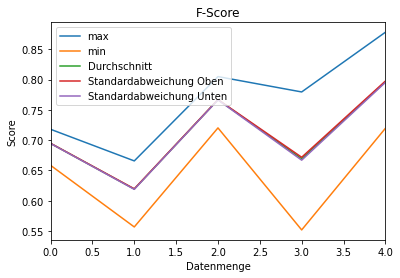

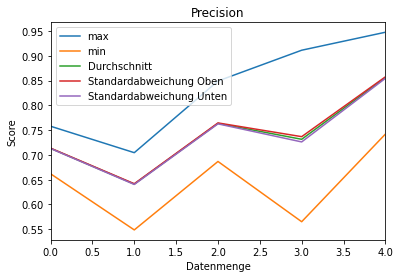

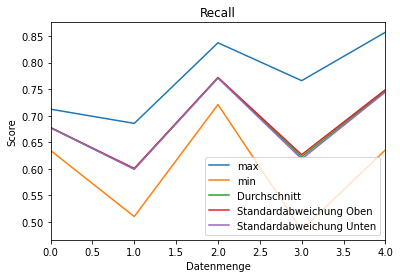

In [9]:
# Min-Max-Werte und Durchschnittswerte inkl. Standardabweichungen
# x = 0 = Gesamt, x = 1 = Skill, x = 2 = Tätigkeit, x = 3 = Branche, x = 4 = Rolle

xWerte = [0,1,2,3,4]
varianzPlusFScore = []
varianzMinusFScore = []
varianzPlusPrecision = []
varianzMinusPrecision = []
varianzPlusRecall = []
varianzMinusRecall = []
for i in range(len(fScores)):
    varianzPlusFScore.append(averageFScores[i] + varianzFScores[i])
    varianzMinusFScore.append(averageFScores[i] - varianzFScores[i])
    varianzPlusPrecision.append(averagePrecisions[i] + varianzPrecisions[i])
    varianzMinusPrecision.append(averagePrecisions[i] - varianzPrecisions[i])
    varianzPlusRecall.append(averageRecalls[i] + varianzRecalls[i])
    varianzMinusRecall.append(averageRecalls[i] - varianzRecalls[i])
    
plt.title('F-Score')
plt.plot(xWerte,maxFScores, label="max")
plt.plot(xWerte,minFScores, label="min")
plt.plot(xWerte,averageFScores, label="Durchschnitt")
plt.plot(xWerte,varianzPlusFScore, label="Standardabweichung Oben")
plt.plot(xWerte,varianzMinusFScore, label="Standardabweichung Unten")
plt.xlim(0,4)
plt.xlabel('Datenmenge')
plt.ylabel('Score')
plt.legend()
plt.show()

plt.title('Precision')
plt.plot(xWerte,maxPrecisions, label="max")
plt.plot(xWerte,minPrecisions, label="min")
plt.plot(xWerte,averagePrecisions, label="Durchschnitt")
plt.plot(xWerte,varianzPlusPrecision, label="Standardabweichung Oben")
plt.plot(xWerte,varianzMinusPrecision, label="Standardabweichung Unten")
plt.xlim(0,4)
plt.xlabel('Datenmenge')
plt.ylabel('Score')
plt.legend()
plt.show()

plt.title('Recall')
plt.plot(xWerte,maxRecalls, label="max")
plt.plot(xWerte,minRecalls, label="min")
plt.plot(xWerte,averageRecalls, label="Durchschnitt")
plt.plot(xWerte,varianzPlusRecall, label="Standardabweichung Oben")
plt.plot(xWerte,varianzMinusRecall, label="Standardabweichung Unten")
plt.xlim(0,4)
plt.xlabel('Datenmenge')
plt.ylabel('Score')
plt.legend()
plt.show()

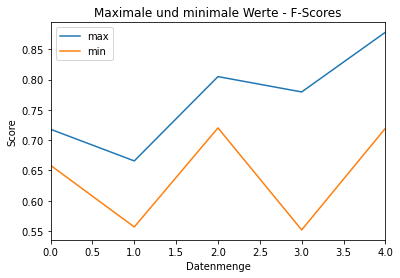

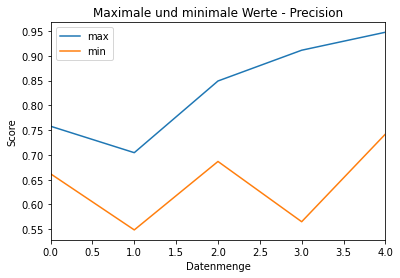

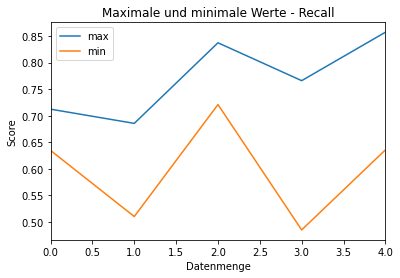

In [10]:
# Min-Max-Werte
plt.title('Maximale und minimale Werte - F-Scores')
plt.plot(xWerte,maxFScores, label="max")
plt.plot(xWerte,minFScores, label="min")
plt.xlim(0,4)
plt.xlabel('Datenmenge')
plt.ylabel('Score')
plt.legend()
plt.show()

plt.title('Maximale und minimale Werte - Precision')
plt.plot(xWerte,maxPrecisions, label="max")
plt.plot(xWerte,minPrecisions, label="min")
plt.xlim(0,4)
plt.xlabel('Datenmenge')
plt.ylabel('Score')
plt.legend()
plt.show()

plt.title('Maximale und minimale Werte - Recall')
plt.plot(xWerte,maxRecalls, label="max")
plt.plot(xWerte,minRecalls, label="min")
plt.xlim(0,4)
plt.xlabel('Datenmenge')
plt.ylabel('Score')
plt.legend()
plt.show()

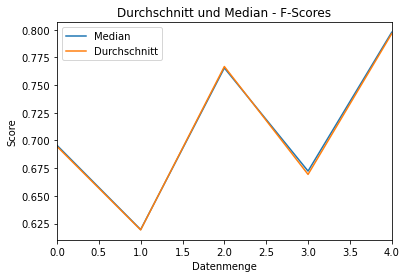

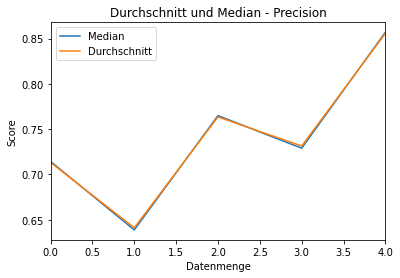

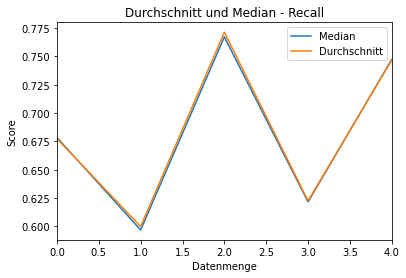

In [11]:
# Median und Durchschnittswerte 

plt.title('Durchschnitt und Median - F-Scores')
plt.plot(xWerte,mediansFScores, label="Median")
plt.plot(xWerte,averageFScores, label="Durchschnitt")
plt.xlim(0,4)
plt.xlabel('Datenmenge')
plt.ylabel('Score')
plt.legend()
plt.show()

plt.title('Durchschnitt und Median - Precision')
plt.plot(xWerte,mediansPrecisions, label="Median")
plt.plot(xWerte,averagePrecisions, label="Durchschnitt")
plt.xlim(0,4)
plt.xlabel('Datenmenge')
plt.ylabel('Score')
plt.legend()
plt.show()

plt.title('Durchschnitt und Median - Recall')
plt.plot(xWerte,mediansRecalls, label="Median")
plt.plot(xWerte,averageRecalls, label="Durchschnitt")
plt.xlim(0,4)
plt.xlabel('Datenmenge')
plt.ylabel('Score')
plt.legend()
plt.show()

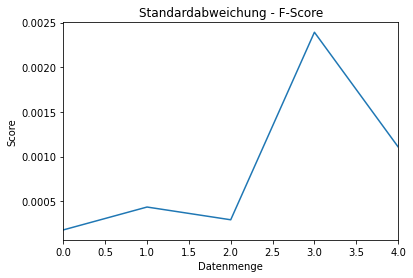

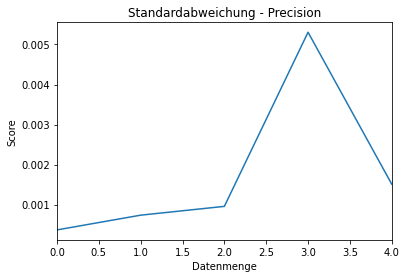

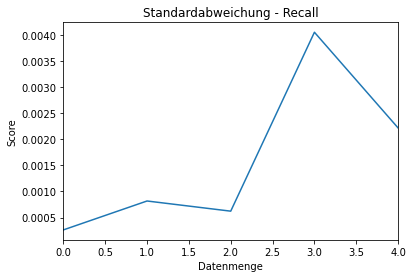

In [13]:
# Standardabweichung

plt.title('Standardabweichung - F-Score')
plt.plot(xWerte,varianzFScores)
plt.xlim(0,4)
plt.xlabel('Datenmenge')
plt.ylabel('Score')
plt.show()

plt.title('Standardabweichung - Precision')
plt.plot(xWerte,varianzPrecisions)
plt.xlim(0,4)
plt.xlabel('Datenmenge')
plt.ylabel('Score')
plt.show()

plt.title('Standardabweichung - Recall')
plt.plot(xWerte,varianzRecalls)
plt.xlim(0,4)
plt.xlabel('Datenmenge')
plt.ylabel('Score')
plt.show()

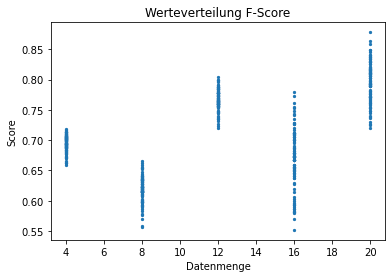

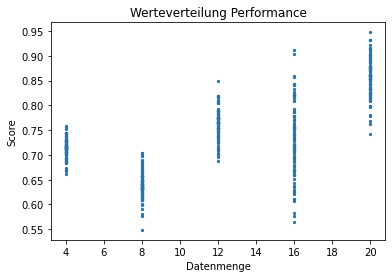

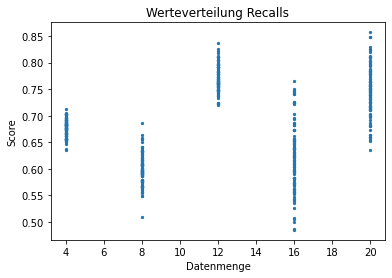

In [15]:
#Werteverteilungen

x = []
yf = []
yp = []
yr = []
for i in range(len(fScores)):
    for j in range(len(fScores[i])):
        x.append((i+1)*4)
        yf.append(fScores[i][j])
        yp.append(precisions[i][j])
        yr.append(recalls[i][j])

plt.title('Werteverteilung F-Score')
plt.scatter(x, yf, s=5)
plt.xlabel('Datenmenge')
plt.ylabel('Score')
plt.show()


plt.title('Werteverteilung Performance')
plt.scatter(x, yp, s=5)
plt.xlabel('Datenmenge')
plt.ylabel('Score')
plt.show()

plt.title('Werteverteilung Recalls')
plt.scatter(x, yr, s=5)
plt.xlabel('Datenmenge')
plt.ylabel('Score')
plt.show()